# Анализ оттока клиентов телеком компании

**Цель** - построить и обучить модель, которая будет прогнозировать отток клиентов. Целевая метрика - **ROC-AUC** не ниже 0.88

**Описание**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на 1 февраля 2020.

**План работы**:
 1. Анализ и предобработка данных: 
    - поиск пропущенных значений, аномалий и дубликатов, их обработка
    - создание столбца с целевым признаком
    - объединение файлов в один. 
 2. Исследовательский анализ данных:
    - сравнение распределения величин ежемесячных платежей всех клиентов и тех, кто ушел
    - рассчет стастических метрик для всех клиентов и тех, кто ушел: медиана, среднее, мин, мах, квантили
    - графики, отображающие долю интернет-пользователей и пользователей телефонной связи
 3. Подготовка данных для моделей:
    - разделение данных на обучающую и тестовую выборки
    - кодирование категориальных признаков
    - маcштабирование количественных признаков
    - анализ баланса классов
 4. Обучение простых моделей:
    - обучение простых моделей с автоподобором дисбаланса классов
    - обучение простых моделей с учетом дисбаланса классов (upsamaple, downsamle)
 5. Тестирование лучшей модели
 6. Обучение моделей градиентного бустинга
 7. Тестирование лучшей модели градиентного бустинга
 8. Общие выводы

## 1. Анализ и предобработка данных

In [2]:
import pandas as pd
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, roc_curve, make_scorer,roc_auc_score, recall_score
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import category_encoders as ce
from category_encoders import OneHotEncoder
import collections

In [3]:
try:  # local import
    df_contract = pd.read_csv('/Users/iyaneklyudova/Downloads/final_provider/contract.csv', na_values=' ')
    df_internet = pd.read_csv('/Users/iyaneklyudova/Downloads/final_provider/internet.csv', na_values=' ')
    df_personal = pd.read_csv('/Users/iyaneklyudova/Downloads/final_provider/personal.csv', na_values=' ')
    df_phone = pd.read_csv('/Users/iyaneklyudova/Downloads/final_provider/phone.csv', na_values=' ')

except:  # from Praktikum server
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv', na_values=' ')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv', na_values=' ')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv', na_values=' ')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv', na_values=' ')

**Данные о договоре**

Посмотрим общую информацию о файле

In [4]:
display(df_contract.head())
df_contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [5]:
print('Количество дубликатов:', df_contract.duplicated().sum())
print('Количество уникальных пользователей:', len(df_contract['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 7043


В файле данные о 7043 уникальных пользователях. Дубликатов нет, но есть пропуски. Колонки с датой `BeginDate` (дата начала пользования услугами) и `EndDate` (дата окончания пользования услугами) имеют тип категориальных данных. Необходимо поменять.

Посмотрим на пропуски

In [6]:
nan_number = df_contract.isna().sum()
print(nan_number)

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64


Посмотрим на строки с пропусками в колонке `TotalCharges`.

In [7]:
print('Доля пропусков', 11/7043 *100 )

Доля пропусков 0.1561834445548772


In [8]:
df_contract_empty = df_contract.query('TotalCharges == "nan"')
display(df_contract_empty)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Все пропуски по пользователям, которые стали клиентами 1 февраля 2020 года. Это дата когда делался срез данных. Так как они только присоединились, их поведение не понятно (останутся или уйдут) и таких пользователей всего 11 (0,15% от общего числа), то удалим эти строки чтобы не портить обучение моделей.

In [9]:
df_contract=df_contract.dropna()
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7032 non-null object
BeginDate           7032 non-null object
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


Поменяем тип данных у колонки `BeginDate` на дату

In [10]:
df_contract['BeginDate']= pd.to_datetime(df_contract['BeginDate'], format ='%Y-%m-%d')

Создадим колонку `СlientGroup`, которая показывает является ли пользователь клиентом или уже ушел, основываясь на данных в колонке `EndDate`. Если даты в колонке нет, то пользователь является клиентом , если дата есть, то ушел.

In [11]:
def client_group(EndDate):
    try:
        if EndDate == 'No':
            return 0
        else:
            return 1
    except:
        print('ошибочное значение')
        
df_contract['СlientGroup'] =  df_contract['EndDate'].apply(client_group) 
display(df_contract.head())
df_contract['СlientGroup'].unique()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


array([0, 1])

Посчитаем в отдельной колонке время жизни клиента `Lifetime`. Создадим копию колонки `EndDate` и заменим значение No на дату 2020-02-01 - дата когда делался срез данных. И вычислим разницу между `EndDateCopy` и `BeginDate` в днях.

In [12]:
df_contract['EndDateCopy']=df_contract['EndDate']
df_contract['EndDateCopy']=df_contract['EndDateCopy'].replace('No', '2020-02-01')
df_contract['EndDateCopy']=pd.to_datetime(df_contract['EndDateCopy'], format ='%Y-%m-%d')
df_contract['Lifetime']=(df_contract['EndDateCopy']-df_contract['BeginDate']).dt.days
df_contract=df_contract.drop(['EndDateCopy'], axis=1)
display(df_contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [13]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
СlientGroup         7032 non-null int64
Lifetime            7032 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 604.3+ KB


**Данные об интернет услугах**

Посмотрим общую информацию о файле

In [14]:
display(df_internet.head())
df_internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
print('Количество дубликатов:', df_internet.duplicated().sum())
print('Количество уникальных пользователей:', len(df_internet['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 5517


Дубликатов и пропусков нет, но кол-во пользователей только 5517. Это меньше чем кол-во пользователей в данных о договоре. Значит есть пользователи, которые не пользуются интернетом и дополнительными услугами.

**Персональные данные клиентов**

In [16]:
display(df_personal.head())
df_personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [17]:
print('Количество дубликатов:', df_personal.duplicated().sum())
print('Количество уникальных пользователей:', len(df_personal['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 7043


Дубликатов и пропусков нет

**Данные о телефонной связи**

In [18]:
display(df_phone.head())
df_phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


In [19]:
print('Количество дубликатов:', df_phone.duplicated().sum())
print('Количество уникальных пользователей:', len(df_phone['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 6361


Дубликатов и пропусков нет, но кол-во пользователей только 6361. Это меньше чем кол-во пользователей в данных о договоре. Значит есть пользователи, которые не пользуются услугами телефонной связи.

Пропуски в столбце `TotalCharges` удалены, тк их всего 11 шт, добавлен столбец `СlientGroup` с целевым признаком и столбец с дополнительным признаком `Lifitime` - время жизни клиента. 

Можно объединять данные в один датасет

**Объединение данных**

Сначала объединим персональные данные и данные о контрактах. Изначально в обоих файлах было 7043 записей, но мы удалили 11 записей из данных о контрактах. Поэтому после объединения, удалим пропуски в общем файле. 

In [20]:
df_full = pd.merge(df_personal, df_contract, on ='customerID',how= 'left')
df_full=df_full.dropna()
display(df_full.head())
df_full.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 14 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
СlientGroup         7032 non-null float64
Lifetime            7032 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(8)
memory usage: 824.1+ KB


Теперь объединим с остальными данными, где было записей меньше чем 7043

In [21]:
df_full = pd.merge(df_full, df_phone, on ='customerID',how= 'left')
df_full = pd.merge(df_full, df_internet, on ='customerID',how= 'left')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
СlientGroup         7032 non-null float64
Lifetime            7032 non-null float64
MultipleLines       6352 non-null object
InternetService     5512 non-null object
OnlineSecurity      5512 non-null object
OnlineBackup        5512 non-null object
DeviceProtection    5512 non-null object
TechSupport         5512 non-null object
StreamingTV         5512 non-null object
StreamingMovies     5

Записей в данных о пользовании услуг телефонной связи и интернета было меньше, чем в данных о контрактах, тк не все пользуются и телефоном и интернетом одновременно. Проверим сначала нет ли тех кто не пользуется ни тем ни другим

In [22]:
display(df_full[(df_full['MultipleLines'].isna())&(df_full['InternetService'].isna())])

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


Таких нет, поэтому заменим пропуски на **Do not use** - не пользуется. Так же поменяем тип у колонок `СlientGroup`  и `Lifitime` на целочисленный

In [23]:
df_full[['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
         'StreamingTV', 'StreamingMovies']]=df_full[['MultipleLines','InternetService','OnlineSecurity',
        'OnlineBackup','DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']].fillna('Do not use')
df_full[['СlientGroup', 'Lifetime']]=df_full[['СlientGroup', 'Lifetime']].astype('int64')
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
СlientGroup         7032 non-null int64
Lifetime            7032 non-null int64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 

In [24]:
print('Количество дубликатов:', df_full.duplicated().sum())

Количество дубликатов: 0


**Выводы**. Пропуски обработаны, дубликатов нет. Добавлен один дополнительный признак и создана колонка с целевым признаком. Все данные объединены в одну таблицу.

## 2. Исследовательский анализ данных

Сделаем выборку по ушедшим клиентам

In [25]:
df_notclient= df_full[(df_full['СlientGroup']==1)]
df_notclient.shape
print(len(df_notclient)/len(df_full)*100)

26.578498293515356


In [26]:
df_notclient.shape

(1869, 22)

Ушло 1869 аббонентов - это 26,6% клиентов. 

Напишем функцию для расчета статистических метрик по всем клиентам и по ушедшим клиентам

In [27]:
def measures(column):
    filtered_df_full=df_full[column]
    filtered_df_notclient=df_notclient[column]
    mean_full = filtered_df_full.mean()
    mean_notclient =  filtered_df_notclient.mean()
    median_full = filtered_df_full.median()
    median_notclient =  filtered_df_notclient.median()
    min_full = filtered_df_full.min()
    min_notclient =  filtered_df_notclient.min()
    max_full = filtered_df_full.max()
    max_notclient =  filtered_df_notclient.max()
    q1_full = filtered_df_full.quantile(0.25)
    q3_full = filtered_df_full.quantile(0.75)
    q1_notclient = filtered_df_notclient.quantile(0.25)
    q3_notclient = filtered_df_notclient.quantile(0.75)
    print ('\033[94m'+column+'\033[0m')
    print('\033[1m'+'Все клиенты:'+'\033[0m')  
    print('Медиана: {:.0f}'.format(median_full),', Среднее: {:.0f}'.format(mean_full),
          ', Минимальное значение: {:.0f}'.format(min_full), ',  Максимальное значение: {:.0f}'.format(max_full),
          ', 25% квантиль: {:.0f}'.format(q1_full), ', 75% квантиль: {:.0f}'.format(q3_full))
    print ('\033[1m'+'Ушедшие клиенты:'+'\033[0m')
    print('Медиана: {:.0f}'.format(median_notclient),', Среднее: {:.0f}'.format(mean_notclient),
          ', Минимальное значение: {:.0f}'.format(min_notclient), ',  Максимальное значение: {:.0f}'.format(max_notclient),
          ', 25% квантиль: {:.0f}'.format(q1_notclient), ', 75% квантиль: {:.0f}'.format(q3_notclient))

Посмотрим на метрики по данным о ежемесячных платежах. 

In [28]:
measures('MonthlyCharges')

MonthlyCharges
Все клиенты:
Медиана: 70 , Среднее: 65 , Минимальное значение: 18 ,  Максимальное значение: 119 , 25% квантиль: 36 , 75% квантиль: 90
Ушедшие клиенты:
Медиана: 80 , Среднее: 74 , Минимальное значение: 19 ,  Максимальное значение: 118 , 25% квантиль: 56 , 75% квантиль: 94


У ушедших клиентов средний платеж (и медиана) выше, чем в целом у всех клиентов. Максимальное и минимальное значения  примерно одинаковые у обеих групп. Большие различия видны в 25% квантилях. В общей выборке четверть клиентов платит ежемесячно меньше 36, а среди ушедших клиентов четверть платит меньше 56.

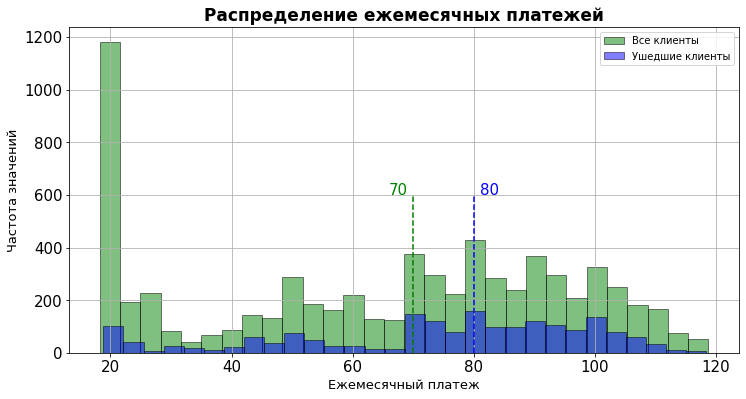

In [29]:
ax = df_full.plot(kind='hist', y='MonthlyCharges', ec='black', bins=30, 
                              linewidth=1, alpha=0.5, label='Все клиенты', color='g')
df_notclient.plot(kind='hist', y='MonthlyCharges', ec='black', bins=30,linewidth=1, alpha=0.5, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
ax.vlines(70, 0, 600, color= 'g', linestyle ='--',)
ax.vlines(80, 0, 600, color= 'b', linestyle ='--',)
ax.text(81, 600, '80', fontsize=15, color='b')
ax.text(66, 600, '70', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Ежемесячный платеж', fontsize=13)
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

По графику видно, что среди ушедших клиентов больше всего тех, у кого ежемесячный платеж был в интервале от 70 до 110. Среди всех клиентов очень много тех кто платит в месяц 20. Из этого можно предположить, что большой размер ежемесячного платежа повышает вероятность что клиент уйдет.

Но на графике также видно, что клиентов с ежемесячным платежом в 20 уходило больше, чем клиентов с ежемесячным платежом, например, в 60. Т.е. есть еще факторы, влияющие на уход клиента.


Посмотрим на время жизни ушедших клиентов.

In [30]:
notclient=df_notclient.pivot_table(index= 'Lifetime', values = 'customerID', aggfunc= 'count')
notclient.columns=['count']
display(notclient.sort_values(by='count', ascending= False).head(10))

,count
Lifetime,
31,198
30,182
61,123
153,64
92,63
122,58
214,51
365,38
91,31


Больше всего клиентов ушло через 30, 31 и 61 день после подключения, те всего через 1-2 месяца. Эти клиенты могли быть недовольны качеством услуг или соотношением цена-качество. 

Посмотрим распределение времени жизни клиентов на графике

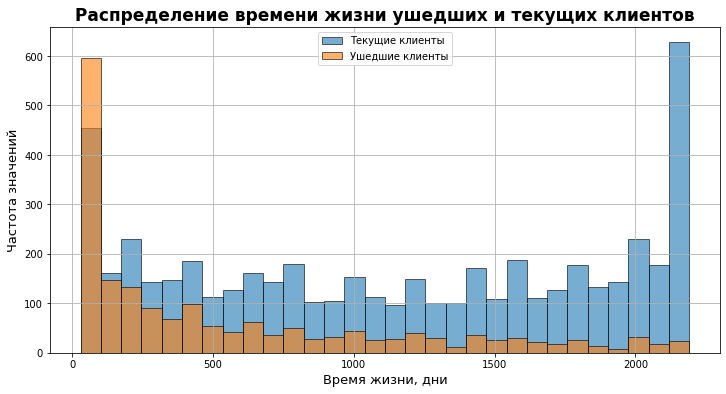

In [31]:
notclient_payment=df_full.pivot_table(index= df_full.index, values = 'Lifetime', columns='СlientGroup').plot.hist(
               figsize=(12,6), alpha=0.6, ec='black', grid=True, bins=30)
plt.ylabel('Частота значений', fontsize=13)
plt.xlabel('Время жизни, дни', fontsize=13)
plt.title('Распределение времени жизни ушедших и текущих клиентов', fontsize=17, fontweight='bold')
plt.legend(['Текущие клиенты', 'Ушедшие клиенты'])
plt.show()

На графике видно что большинство клиентов уходит через непродолжительное время после заключения контракта. Чем дольше длится контракт, тем выше вероятность, что клиент останется.

 Проведем анализ поведения клиентов

**Все клиенты**

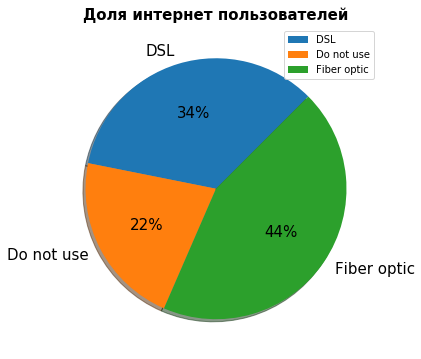

In [32]:
df_full.pivot_table(index='InternetService', values='customerID', 
                aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                fontsize=15,figsize= (6,6), startangle =45,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля интернет пользователей', fontsize=15, fontweight='bold')
plt.show()

In [33]:
def phone_user(MultipleLines):  #объединим пользователей телефонной связи с наличием 
                                #параллельных линий и без в одну группу -  User. 
    try:
        if MultipleLines == 'No' or MultipleLines== 'Yes':
            return 'User'
        else:
            return 'Do not use'
    except:
        print('ошибочное значение')
df_full['phone_user'] =  df_full['MultipleLines'].apply(phone_user) 
df_full['phone_user'].unique()

array(['Do not use', 'User'], dtype=object)

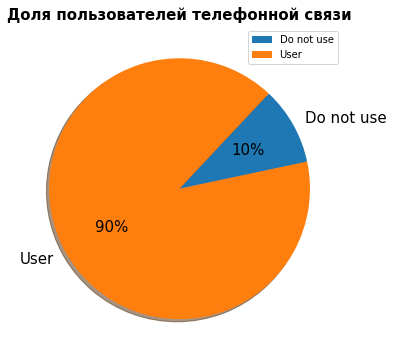

In [34]:
df_full.pivot_table(index='phone_user', values='customerID', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                fontsize=15, figsize= (6,6), startangle =12,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля пользователей телефонной связи', fontsize=15, fontweight='bold')
plt.show()

Среди всех клиентов 10% не пользуется услугами телефонной связи и 22% не пользуются интернетом. Среди пользователей интернета 34% подключаются через телефонную линию (DSL) и немного больше - 44% через оптоволоконный кабель (Fiber optic).  

**Ушедшие клиенты**

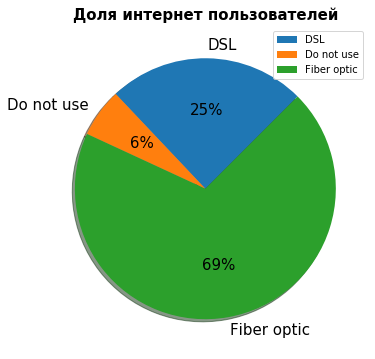

In [35]:
df_notclient.pivot_table(index='InternetService', values='customerID', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                 fontsize=15, figsize= (6,6), startangle =45,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля интернет пользователей', fontsize=15, fontweight='bold')
plt.show()

In [36]:
def phone_user(MultipleLines):     #объединим пользователей телефонной связи с наличием 
                                   #параллельных линий и без в одну группу -  User.
    try:
        if MultipleLines == 'No' or MultipleLines== 'Yes':
            return 'User'
        else:
            return 'Do not use'
    except:
        print('ошибочное значение')
        
df_notclient['phone_user'] =  df_notclient['MultipleLines'].apply(phone_user) 
df_notclient['phone_user'].unique()

array(['User', 'Do not use'], dtype=object)

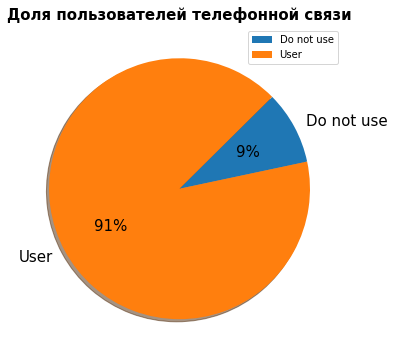

In [37]:
df_notclient.pivot_table(index='phone_user', values='customerID', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                 fontsize=15,figsize= (6,6), startangle =12,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля пользователей телефонной связи', fontsize=15, fontweight='bold')
plt.show()

Среди ушедших клиентов только 9% не пользовались телефонной связью и 6% не пользовались интернетом. Больше всего из пользователей интернета ушло тех, кто подключался через оптоволоконный кабель (Fiber optic). Можно предположить что ушедшие клиенты были недовольны качеством интернет соединения.  

**Выводы** 26.6% процентов клиентов разорвали контракт с компанией. У ушедших клиентов средний месячный платеж выше, чем в целом у всех клиентов. Больше всего уходит клиентов через 1-2 месяца после заключения контракта. Можно предположить, что клиенты уходят из-за того что недовольны соотношением цена-качество услуг. Среди ушедших много тех, кто подключался к интернету через оптоволоконный кабель (Fiber optic).

То есть в первую очередь стоит обратить внимание на только подключившихся клиентов с ежемесячным платежом выше, чем в среднем по всем клиентам - 65.

## 3. Подготовка данных для моделей

Посмотрим какие колонки нам не понадобятся.

Проверим корреляцию количественных признаков.

In [38]:
display(df_full.corr())

,SeniorCitizen,MonthlyCharges,TotalCharges,СlientGroup,Lifetime
SeniorCitizen,1.000000,0.219874,0.102411,0.150541,0.015630
MonthlyCharges,0.219874,1.000000,0.651065,0.192858,0.246715
TotalCharges,0.102411,0.651065,1.000000,-0.199484,0.825811
СlientGroup,0.150541,0.192858,-0.199484,1.000000,-0.354496
Lifetime,0.015630,0.246715,0.825811,-0.354496,1.000000


Корреляция между `TotalCharges` и `Lifetime` больше чем 0.8. Удалим `TotalCharges`, тк есть `MonthlyCharges` 

In [39]:
 df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
СlientGroup         7032 non-null int64
Lifetime            7032 non-null int64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 

Колонка `customerID` не несет в себе никакой полезной информации, `phone_user` создавалась только для анализа поведения пользователей, а `BeginDate` и `EndDate` могут привести к утечке данных- вместо них оставим только колонку время жизни клиента `Lifetime`

Все категориальные признаки имеют тип данных object, кроме данных в колонке `SeniorCitizen`. Преобразуем их в object.

Колонка `СlientGroup` будет целевым признаком. Остальные колонки: `MonthlyCharges`, `Lifetime` - количественные признаки

In [40]:
df_full=df_full.drop(['customerID','BeginDate','EndDate', 'phone_user', 'TotalCharges'], axis =1)
df_full['SeniorCitizen']=df_full['SeniorCitizen'].replace( 0 , 'No')
df_full['SeniorCitizen']=df_full['SeniorCitizen'].replace( 1 , 'Yes')

In [41]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 18 columns):
gender              7032 non-null object
SeniorCitizen       7032 non-null object
Partner             7032 non-null object
Dependents          7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
СlientGroup         7032 non-null int64
Lifetime            7032 non-null int64
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
dtypes: float64(1), int64(2), object(15)
memory usage: 1.0+ MB


Разобъем данные на признаки и целевой признак и разделим их на 2 выборки: обучающую и тестовую в пропорции 70:30.

In [42]:
target = df_full['СlientGroup'] # столбец с целевым признаком
features = df_full.drop(['СlientGroup'], axis=1) # таблица с признаками. 
features_train, features_test, target_train, target_test = train_test_split(
        features,target,stratify=target, test_size=0.3, random_state=12345)
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (4922, 17) (4922,)
Тестовая выборка:  (2110, 17) (2110,)


Поделилось корректно. Теперь проведем кодирование категориальных переменных. 

In [44]:
features_train_ohe=pd.get_dummies(features_train, drop_first=True)
features_test_ohe=pd.get_dummies(features_test, drop_first=True)


In [45]:
display(features_test_ohe.head())
features_test_ohe.shape

,MonthlyCharges,Lifetime,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No,MultipleLines_Yes,InternetService_Do not use,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
309,78.75,1461,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,1
5313,81.90,792,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1
1712,19.70,2191,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3629,24.55,2191,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3149,72.75,123,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0


(2110, 28)

Проведем масштабирование количественных признаков

In [46]:
numeric=['MonthlyCharges', 'Lifetime']
scaler=StandardScaler()
scaler.fit((features_train_ohe[numeric]))
features_train_ohe[numeric]=scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric]=scaler.transform(features_test_ohe[numeric])
display(features_train_ohe.shape)
display(features_train_ohe.head())

(4922, 28)

,MonthlyCharges,Lifetime,gender_Male,SeniorCitizen_Yes,Partner_Yes,Dependents_Yes,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,MultipleLines_No,MultipleLines_Yes,InternetService_Do not use,InternetService_Fiber optic,OnlineSecurity_No,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes
6325,1.298360,1.413795,0,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1
2432,-0.115736,-1.040535,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0
6352,-0.069263,-1.040535,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1
3813,-1.133154,0.553570,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0
3122,-1.138134,-0.142675,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0


Проверим баланс классов в целевом признаке

0    0.734215
1    0.265785
Name: СlientGroup, dtype: float64


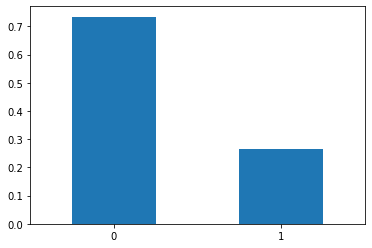

In [47]:
class_frequency=target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Дисбаланс классов примерно 1:3

## 4. Обучение простых моделей

Сначала для обучения возьмем несколько простых моделей: Логистическая регрессия, Дерево решений и Случайный лес

Напишем функцию для кроссвалидации по модели.

In [48]:
def calc(model, features, target, params):
    roc_auc_scorer=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    grid= GridSearchCV(model, params, scoring=roc_auc_scorer, cv=5, n_jobs = -1)
    grid.fit(features, target)
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)
    print('Лучшая метрика ROC_AUC: {:.3f}'.format(grid.best_score_))

Сначала попробуем кроссвалидацию с встроенной борьбой с дисбалансом по гипперпараметру  class_weight

**Логистическая регрессия**

In [49]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={'class_weight':['balanced',None], 'C':[2, 5,8]}
calc(regress, features_train_ohe, target_train, regress_params )

Лучшие гиперпараметры для модели:  {'C': 8, 'class_weight': None}
Лучшая метрика ROC_AUC: 0.842
CPU times: user 129 ms, sys: 53.4 ms, total: 183 ms
Wall time: 1.7 s


Кроссвалидация показала, что лучшая метрика ROC_AUC =0.842 достигается, если class_weight не применять. 

**Дерево решений**

In [50]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 17, 5),'class_weight':['balanced',None]}
calc(tree, features_train_ohe, target_train, tree_params )

Лучшие гиперпараметры для модели:  {'class_weight': 'balanced', 'max_depth': 6}
Лучшая метрика ROC_AUC: 0.843
CPU times: user 55.2 ms, sys: 5.65 ms, total: 60.9 ms
Wall time: 327 ms


Кроссвалидация показала, что лучшая метрика ROC_AUC =0.843 также достигается, если class_weight не применять. Метрика немного хуже чем у логистической регрессии

**Случайный лес**

In [51]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 13, 2), 'class_weight':['balanced',None], 'n_estimators':range(1,45,5)}
calc(forest, features_train_ohe, target_train,forest_params)

Лучшие гиперпараметры для модели:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 31}
Лучшая метрика ROC_AUC: 0.853
CPU times: user 445 ms, sys: 24.9 ms, total: 470 ms
Wall time: 9.4 s


 ROC_AUC=0.853, это лучше чем у логистической регрессии. Но здесь также лучшая модель получается без class_weight 

Попробуем изменить баланс классов вручную.

In [52]:
def upsample(features, target, repeat): #Функция для увеличения положительных объектов в выборке на n-кол-во раз(repeat)
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_upsampled=pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled=pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)
    return features_upsampled, target_upsampled

Увеличим кол-во положительных объектов в выборке в 3 раза

In [53]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 3)
print(features_upsampled.shape)
print(target_upsampled.shape)

(7538, 28)
(7538,)


1    0.520562
0    0.479438
Name: СlientGroup, dtype: float64


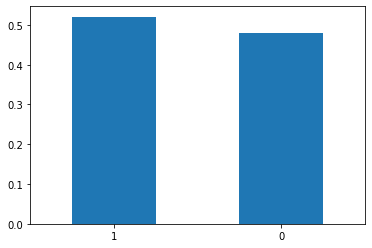

In [54]:
class_frequency=target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

**Логистическая регрессия**

In [55]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={ 'C':[5, 10,15]}
calc(regress, features_upsampled, target_upsampled, regress_params )

Лучшие гиперпараметры для модели:  {'C': 5}
Лучшая метрика ROC_AUC: 0.842
CPU times: user 62.7 ms, sys: 6.63 ms, total: 69.3 ms
Wall time: 322 ms


ROC_AUC не изменился

**Дерево решений**

In [56]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 10, 3)}
calc(tree, features_upsampled, target_upsampled, tree_params )

Лучшие гиперпараметры для модели:  {'max_depth': 7}
Лучшая метрика ROC_AUC: 0.870
CPU times: user 50.2 ms, sys: 6.36 ms, total: 56.5 ms
Wall time: 191 ms


ROC_AUC= 0.870, это значительно больше чем без учета дисбаланса.

**Случайный лес**

In [57]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5)}
calc(forest, features_upsampled, target_upsampled,forest_params)

Лучшие гиперпараметры для модели:  {'max_depth': 9, 'n_estimators': 16}
Лучшая метрика ROC_AUC: 0.903
CPU times: user 151 ms, sys: 9.18 ms, total: 160 ms
Wall time: 1.34 s


ROC_AUC стал гораздо лучше =  0.883

Попоробуем уменьшить кол-во отрицательных объектов  в выборке

In [58]:
def downsample(features, target, fraction):#Функция для уменьшения отрицательных  объектов в выборке на n-долю (fraction)
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+[target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    return features_downsampled, target_downsampled

In [59]:
features_downsampled, target_downsampled = downsample(features_train_ohe, target_train, 0.35)

1    0.508356
0    0.491644
Name: СlientGroup, dtype: float64


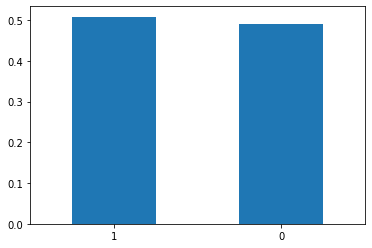

In [60]:
class_frequency=target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

**Логистическая регрессия**

In [61]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={ 'C':[3, 5, 10]}
calc(regress, features_downsampled, target_downsampled, regress_params )

Лучшие гиперпараметры для модели:  {'C': 10}
Лучшая метрика ROC_AUC: 0.837
CPU times: user 39.4 ms, sys: 3.37 ms, total: 42.8 ms
Wall time: 149 ms


**Дерево решений**

In [62]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 17, 5)}
calc(tree, features_downsampled, target_downsampled, tree_params )

Лучшие гиперпараметры для модели:  {'max_depth': 6}
Лучшая метрика ROC_AUC: 0.831
CPU times: user 36.2 ms, sys: 2.99 ms, total: 39.2 ms
Wall time: 193 ms


**Случайный лес**

In [63]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 13, 2), 'n_estimators':range(1,45,5)}
calc(forest,  features_downsampled, target_downsampled,forest_params)

Лучшие гиперпараметры для модели:  {'max_depth': 7, 'n_estimators': 36}
Лучшая метрика ROC_AUC: 0.846
CPU times: user 224 ms, sys: 6.1 ms, total: 230 ms
Wall time: 4.14 s


С downsample результаты у всех 3-х моделей хуше чем с class_weight = None

Посмотрим на результаты в таблице

In [64]:
data_line = {'Модель':['Линейная регрессия' ,'Решающее дерево',  'Случайный лес'], 
        'ROC-AUC без учета баланса': [0.842, 0.843,  0.853],
        'ROC-AUC upsample x3': [0.842, 0.870,  0.903],
       'ROC-AUC downsample x0.35': [0.837,0.831, 0.846]}
data_pivot = pd.DataFrame.from_dict(data_line)

display(data_pivot)

,Модель,ROC-AUC без учета баланса,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Линейная регрессия,0.842,0.842,0.837
1,Решающее дерево,0.843,0.870,0.831
2,Случайный лес,0.853,0.903,0.846


Без учета дисбаланса лучшая метрика ROC-AUC=0.85 у Случайного леса. С upsample x3 метрика улучшается и лучшая  также у Случайного леса = 0.88, что равно пороговому значению. Downsample приводит к ухудшению метрики

Протестируем модель Случайный лес с upsample x3. 

## 5. Тестирование лучшей  модели

Точность:0.531
Полнота:0.784
Accuracy:0.758
AUC-ROC:0.854


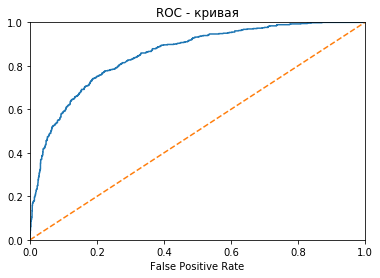

In [65]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 3)
forest = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=9)
forest.fit(features_upsampled, target_upsampled)
predictions_test=forest.predict(features_test_ohe) 
probabilities_test = forest.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.title('ROC - кривая')
print('Точность:{:.3f}' .format(precision_score(target_test, predictions_test)))
print('Полнота:{:.3f}' .format(recall_score(target_test, predictions_test)))
print('Accuracy:{:.3f}' .format(accuracy_score(target_test, predictions_test)))
print('AUC-ROC:{:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))

На тестовой выборке модель показала AUC-ROC= 0.854 и Accuracy=0.758. Не очень высокие показатели. К тому же точность всего 0.53 и на обучающей выборке был AUC-ROC= 0.903, что говорит о небольшом переобучении и со временем модель модель может потерять в качестве. 


## 6. Обучение моделей градиентного бустинга

Попробуем модели градиентого бустинга: CatBoost и LightBGM 

**CatBoost**

Создадим список категориальных признаков

In [66]:
cat_features =['gender', 'SeniorCitizen', 'Partner','Dependents','Type','PaperlessBilling',
               'PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

In [67]:
%%time
cat = CatBoostClassifier(iterations=200, verbose=False,cat_features = cat_features)
cat_params = {'learning_rate':[0.5, 0.8, 1.0], 'depth':[5,10, 15]} 
cat_grid= GridSearchCV(cat, cat_params, scoring='roc_auc',  cv=4, n_jobs = -1)
cat_grid.fit(features_train, target_train)

print('Лучшая метрика AUC-ROC: {:.3f}' .format(cat_grid.best_score_))
print('Лучшие гиперпараметры для модели: ', cat_grid.best_params_)

Лучшая метрика AUC-ROC: 0.906
Лучшие гиперпараметры для модели:  {'depth': 5, 'learning_rate': 0.5}
CPU times: user 3.32 s, sys: 276 ms, total: 3.59 s
Wall time: 24min 52s


AUC-ROC на кроссвалидации 0.906 Это намного лучше чем у простых моделей и выше порога в 0.88.

 **LightGBM**

Поменяем тип категориальных признаков на 'category'

In [68]:
df_full[['gender', 'SeniorCitizen', 'Partner','Dependents','Type','PaperlessBilling',
               'PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']]= df_full[['gender', 
                'SeniorCitizen', 'Partner','Dependents','Type','PaperlessBilling',
               'PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']].astype('category')

In [69]:
target_lgb=df_full['СlientGroup'] # столбец с целевым признаком
features_lgb=df_full.drop(['СlientGroup'], axis=1) # таблица с признаками.
features_train_lgb, features_test_lgb, target_train_lgb, target_test_lgb = train_test_split(
       features_lgb,target_lgb, stratify= target_lgb, test_size=0.3, random_state=12345)

In [70]:
%%time
categorial_features = ['gender', 'SeniorCitizen', 'Partner','Dependents','Type','PaperlessBilling',
               'PaymentMethod','MultipleLines','InternetService','OnlineSecurity','OnlineBackup',
               'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
lgb=LGBMClassifier(num_iteration=500, verbose=0, random_state=12345, categorial_features=categorial_features )
lgb_params = {'learning_rate':[0.05, 0.1, 0.3], 'depth':[5,10, 15],'boosting_type':['gbdt', 'dart', 'goss']}
lgb_grid= GridSearchCV(lgb, lgb_params, scoring='roc_auc',  cv=3, n_jobs = -1)
lgb_grid.fit(features_train_lgb, target_train_lgb)
print('Лучшая метрика AUC-ROC: {:.3f}' .format(lgb_grid.best_score_))
print('Лучшие гиперпараметры для модели: ',lgb_grid.best_params_)

Лучшая метрика AUC-ROC: 0.879
Лучшие гиперпараметры для модели:  {'boosting_type': 'gbdt', 'depth': 5, 'learning_rate': 0.05}
CPU times: user 2.11 s, sys: 39.5 ms, total: 2.14 s
Wall time: 55 s


AUC-ROC=0.879, хуже чем у CatBoost.

Для тестирования возьмем  CatBoost с гиперпараметрами, найденными при кроссвалидации: 'depth': 5, 'learning_rate': 0.5

## 7. Тестирование лучшей модели

Точность: 0.800
Полнота: 0.720
Accuracy: 0.878
AUC-ROC: 0.916
CPU times: user 3.45 s, sys: 252 ms, total: 3.7 s
Wall time: 1.44 s


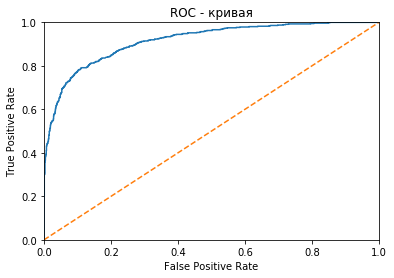

In [71]:
%%time
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features, 
                        learning_rate=0.5,depth=5, random_state=12345)
cat_test.fit(features_train, target_train)
predictions_cat=cat_test.predict(features_test)
probabilities_test =cat_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
print('Точность: {:.3f}' .format(precision_score(target_test, predictions_cat)))
print('Полнота: {:.3f}' .format(recall_score(target_test, predictions_cat)))
print('Accuracy: {:.3f}' .format(accuracy_score(target_test, predictions_cat)))
print('AUC-ROC: {:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))


На тесте AUC-ROC= 0.916 и Accuracy= 0.878. Это выше порога AUC-ROC = 0.88. 

Проверим важность признаков для этой модели

In [72]:
importance = cat_test.feature_importances_
feature_list=list(features_train.columns)
feature_results=pd.DataFrame({'feature': feature_list, 'importance': importance}).sort_values('importance', ascending=False).reset_index(drop=True)
display(feature_results)

,feature,importance
0,Lifetime,57.214145
1,MonthlyCharges,11.685069
2,Type,4.932529
3,TechSupport,4.509663
4,PaymentMethod,3.466323
5,MultipleLines,2.722612
6,OnlineBackup,2.354551
7,InternetService,2.102662
8,OnlineSecurity,1.906594
9,PaperlessBilling,1.900346


Протестируем модель без признаков с низкой важностью

In [73]:
cat_features_filterred = ['Type',
               'PaymentMethod','MultipleLines','OnlineBackup','InternetService',
               'TechSupport','OnlineSecurity']
features_train_filtered = features_train.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'],axis =1 )
features_test_filtered = features_test.drop(['Dependents','Partner','DeviceProtection','StreamingMovies',
                    'SeniorCitizen','StreamingTV','gender','PaperlessBilling'], axis =1)



Точность: 0.802
Полнота: 0.724
Accuracy: 0.879
AUC-ROC: 0.924
CPU times: user 2.35 s, sys: 154 ms, total: 2.51 s
Wall time: 1.19 s


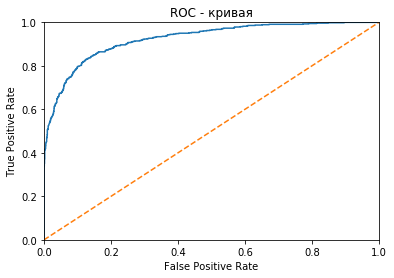

In [74]:
%%time
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features_filterred, 
                        learning_rate=0.5,depth=5, random_state=12345)
cat_test.fit(features_train_filtered, target_train)
predictions_cat=cat_test.predict(features_test_filtered)
probabilities_test =cat_test.predict_proba(features_test_filtered)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
print('Точность: {:.3f}' .format(precision_score(target_test, predictions_cat)))
print('Полнота: {:.3f}' .format(recall_score(target_test, predictions_cat)))
print('Accuracy: {:.3f}' .format(accuracy_score(target_test, predictions_cat)))
print('AUC-ROC: {:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))



AUC-ROC немного повысился и равен 0.924, Accuracy= 0.879. Так же немного увеличились Точность и Полнота. 

Проверим модель на адекватность

Сначала проверим, что модель не предсказывает только какой-то один класс.

In [75]:
collections.Counter(predictions_cat)

Counter({0: 1604, 1: 506})

Предсказывает оба класса

Теперь сравним  модель с константной моделью, которая любому объекту пронозирует класс "0" (тк этого класса большинство)

In [76]:
predictions_train = pd.Series(target_train.replace(1, 0))
print('Accuracy',accuracy_score(target_train, predictions_train))
print('AUC-ROC:', roc_auc_score(target_train, predictions_train))

Accuracy 0.7342543681430312
AUC-ROC: 0.5


У модели метрики Accuracy и AUC-ROC выше чем у константной модели

**Вывод.** Модели удалось превысить порог AUC-ROC=0.88, модель обучена и адекватна

## 8. Общие выводы

Телеком компания предоставила данные в 4 файлах. Необходимо было обучить модель, которая предсказывала бы отток клиентов. Целевая метрика - ROC-AUC не ниже 0.88

После предобаработки данных объединили их в один файл.  
Данные разделили на обучающую и тестовую выборки в пропорции 70:30

Для обучения моделей произвели предобработку признаков: категориальные данные закодировали, количественные отмасштабировали. Для обучения взяли 3 простые модели (Логистическая регрессия, Дерево решений и Случайный лес) и 2 модели градиентного бустинга (CatBoost и LightBGM) и с помощью кроссвалидации нашли оптимальные параметры.

Среди простых моделей лучшей на кроссвалидации оказалась модель Случайный лес. Но на тесте метрика  AUC-ROC не смогла достичь порога 0.88 и accuracy лишь ненамного лучше, чем у константной модели. Среди моделей градиентного бустинга лучшая метрика на кроссвалидации была у модели CatBoost. На тесте метрика  AUC-ROC =0.924 и accuracy=0.879, что лучше чем у константной модели и выше порога AUC-ROC = 0.88. Эту модель можно брать в работу